# Сегментация изображений

## Задача сегментации

Сегментация изображения — задача поиска групп пикселей, каждая из которых характеризует один смысловой объект.

Результатом сегментации, как правило, является маска, которая отделяет различные типы объектов.

<img src="images_seg/segtask0.png" alt="Image segmentation" style="width: 800px; height: 400px;">


Отличием от задачи классификации является то, что результат относится не ко всему изображению, а к его различным фрагментам.

## Подготовка данных

Соответственно задаче, нам понадобится разметка набора данных. Эта разметка должна обеспечить идентификацию местоположения объекта на изображении. Задача очень похожа на задачу классификации, только надо для каждого пикселя сказать, где у нас какой объект. При этом можно провести аналоги между бинарной и многоклассовой классификацией:
* определить, где объект, а где фон
* определить положение нескольких разнотипных объектов на изображении

Чтобы обучить нейросетевую модель, необходимо разметить данные. Разметка заключается в построении маски, похожей на показанную на рисунке ниже. Маска позволяет выделить интересующие объекты.

<img src="images_seg/segtask1.png" alt="Image segmentation" style="width: 800px; height: 400px;">

Если рассмотреть маску ближе, то мы увидим, что каждой точке соответствует значение, обозначающее класс:

<img src="images_seg/mask.png" alt="Image segmentation" style="width: 800px; height: 400px;">

## Сегментация с помощью полосвязной свёрточной нейросети

Для сегментации применяются различные свёрточные нейронные сети:
* FCNN - полностью свёрточная нейросеть
* U-Net
* ResNet
* R-FCN
* Mask R-CNN
* и др.

Полностью свёрточная нейронная сеть - это сеть, которая содержит только свёрточные блоки. Как правило, для классификации такая нейронная сеть снижает размеры и увеличивает количество карт активации. То есть, из исходного изображения она получает набор "сжатых", закодированных данных. Такой вариант организации сети ещё называют кодером.

Для реализации семантической сегментации нам недостаточно получить класс, нам надо получить изображение размером равным исходному, где цветовыми метками выделены объекты (см. рисунки выше).

<img src="images_seg/encdec.png" alt="Image segmentation" style="width: 800px; height: 400px;">


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
from scipy import io
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Activation, \
                         Flatten, Convolution2D, MaxPooling2D, \
                         BatchNormalization, UpSampling2D, Resizing, Rescaling, \
                         RandomBrightness, RandomFlip, RandomRotation
from tensorflow.keras import models, optimizers

In [ ]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git

fatal: destination path 'clothing-co-parsing' already exists and is not an empty directory.


In [ ]:
sample_size = 128
class_count = 59

images = []
for i in range(1,1001):
    url = 'clothing-co-parsing/photos/%04d.jpg'%(i)
    img = cv2.imread(url)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(tf.convert_to_tensor(img))

In [ ]:
masks = []
for i in range(1,1001):
    url = 'clothing-co-parsing/annotations/pixel-level/%04d.mat'%(i)
    file = io.loadmat(url)
    mask = tf.convert_to_tensor(file['groundtruth'])
    masks.append(mask)

In [ ]:
len(images), len(masks)

(1000, 1000)

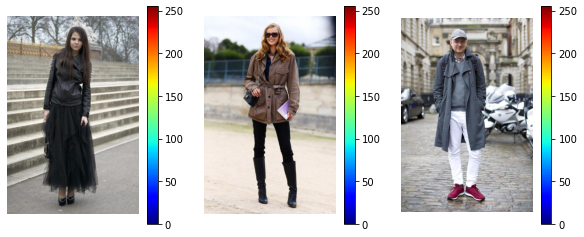

In [ ]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = images[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show() 

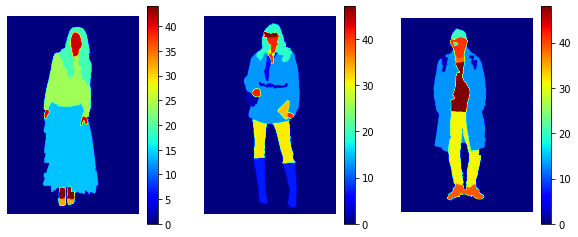

In [ ]:
plt.figure(figsize=(10,4))
for i in range(1,4):
    plt.subplot(1,3,i)
    img = masks[i]
    plt.imshow(img, cmap='jet')
    plt.colorbar()
    plt.axis('off')
plt.show() 

In [ ]:
masks[0].numpy().min(), masks[0].numpy().max()

(0, 55)

In [ ]:
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

def gamma(img, mask):
    img = tf.image.adjust_gamma(img, 0.1)
    return img, mask

def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

def crop(img, mask):
    img = tf.image.central_crop(img, 0.7)
    img = tf.image.resize(img, (128,128))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return img, mask

def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    return img, mask

def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    return img, mask

In [ ]:
def resize_image(image):
    image = tf.cast(image, tf.float32)
    # scale values to [0,1]
    image = image/255.0
    # resize image
    image = tf.image.resize(image, (128,128))
    return image


def resize_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask, tf.uint8)
    return mask

In [ ]:
X = [resize_image(i) for i in images]
y = [resize_mask(m) for m in masks]

In [ ]:
from sklearn.model_selection import train_test_split
train_X, val_X,train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
train_X = tf.data.Dataset.from_tensor_slices(train_X)
val_X = tf.data.Dataset.from_tensor_slices(val_X)
train_y = tf.data.Dataset.from_tensor_slices(train_y)
val_y = tf.data.Dataset.from_tensor_slices(val_y)
train_X.element_spec, train_y.element_spec, val_X.element_spec, val_y.element_spec

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None),
 TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))

In [ ]:
train = tf.data.Dataset.zip((train_X, train_y))
val = tf.data.Dataset.zip((val_X, val_y))

brighted = train.map(brightness);
gammed = train.map(gamma);
hued = train.map(hue);
cropped = train.map(crop);
h_flipped = train.map(flip_hori)
v_flipped = train.map(flip_vert)
rotated = train.map(rotate)

train = train.concatenate(brighted)
train = train.concatenate(gammed)
train = train.concatenate(hued)
train = train.concatenate(cropped)
train = train.concatenate(h_flipped)
train = train.concatenate(v_flipped)
train = train.concatenate(rotated)

In [ ]:
BATCH_SIZE=64
BUFFER_SIZE=1000

In [ ]:
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train = train.prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat(50)
val = val.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
model = Sequential()

model.add(InputLayer((sample_size, sample_size, 3)))

# Кодер
model.add(Convolution2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Convolution2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Convolution2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Декодер

model.add(UpSampling2D(size=(2, 2)))
model.add(Convolution2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='glorot_normal'))
model.add(BatchNormalization())

model.add(UpSampling2D(size=(2, 2)))
model.add(Convolution2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='glorot_normal'))
model.add(BatchNormalization())

model.add( keras.layers.Conv2DTranspose(class_count, 3, strides=2, padding='same'))


model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 256)     7168      
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 256)    1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 256)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 128)       295040    
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                      

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [ ]:
hist = model.fit(train, validation_data=val, steps_per_epoch=800, validation_steps=200, epochs=5)

Epoch 1/5
800/800 [==============================] - 246s 305ms/step - loss: 1.1434 - accuracy: 0.7605 - val_loss: 0.8291 - val_accuracy: 0.7967
Epoch 2/5
800/800 [==============================] - 248s 311ms/step - loss: 0.7973 - accuracy: 0.7983 - val_loss: 0.8950 - val_accuracy: 0.7838
Epoch 3/5
800/800 [==============================] - 247s 309ms/step - loss: 0.7193 - accuracy: 0.8134 - val_loss: 0.7897 - val_accuracy: 0.8056
Epoch 4/5
800/800 [==============================] - 246s 308ms/step - loss: 0.6689 - accuracy: 0.8242 - val_loss: 0.7357 - val_accuracy: 0.8159
Epoch 5/5
800/800 [==============================] - 246s 308ms/step - loss: 0.6302 - accuracy: 0.8334 - val_loss: 0.7688 - val_accuracy: 0.8127


2/2 [==============================] - 0s 56ms/step


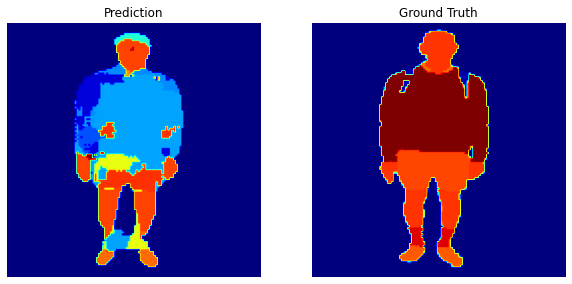

In [ ]:
img, mask = next(iter(val))
pred = model.predict(img)
plt.figure(figsize=(10,5))
for i in pred:
    plt.subplot(121)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet')
    plt.axis('off')
    plt.title('Prediction')
    break
plt.subplot(122)
plt.imshow(mask[0], cmap='jet')
plt.axis('off')
plt.title('Ground Truth')
plt.show()

## Сегментация набора данных домашних питомцев с помощью гибридной остаточной сети с U-Net подобной архитектурой

Архитектура U-Net является логичным развитием архитектуры кодер-декодер.

Как мы знаем, кодер извлекает свойства изображения, а декодер разворачивает их в карту объектов. При развёртывании используются блоки повышения размерности и транспонированные свёртки. Пример сети U-Net показан на рисунке ниже. Число слоёв, карт активации и их размеры могут отличаться, но общая архитектура остаётся.

<img src="images_seg/unet.png" alt="Image segmentation" style="width: 980px; height: 400px;">

**Особенностью сетей U-Net является наличие обходных соединений (skip connections) между кодером и декодером. Эти соединения позволяют корректно восстановить положение пикселей при повышении размерности карт активации за счёт использования исходной информации с этапа кодирования.**

Реализовать архитектуру U-Net можно по-разному: можно это делать, используя функциональный интерфейс TensorFlow, а можно добавлять слои в модель, ограничившить API Keras.

Другим типом U-Net подобных сетей являются сети, где обходные соединения необязательно подключаются строго к противоположным блокам. Такие сети называют ResNet.

В любом случае, так как сеть требует конкатенации входных данных свёрток понижающего блока кодера с результатами повышения размерности декодера, нам будет удобднее определить функции, которые создают повышающие и понижающие блоки сети. Далее нам останется только собрать из них готовую модель.

Рассмотрим сегментацию изображений из набора данных Оксфорда, содержащего снимки домашних питомцев.

### Загрузим данные

Данные содержатся в двух архивах: один архив содержит изображения, а второй - размеченные маски.

In [ ]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz -O images.tar.gz
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz -O annotations.tar.gz

--2023-03-26 18:54:08--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2023-03-26 18:54:08--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz.2’

images.tar.gz.2     100%[===================>] 755.23M  29.6MB/s    in 26s     

2023-03-26 18:54:34 (28.9 MB/s) - ‘images.tar.gz.2’ saved [791918971/791918971]

--2023-03-26 18:54:35--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox

In [ ]:
!tar -zxf images.tar.gz
!tar -zxf annotations.tar.gz

Получим пути к изображениям и маскам и покажем первые 10.

In [ ]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


Отобразим какой-нибудь пример изображения и разметки.

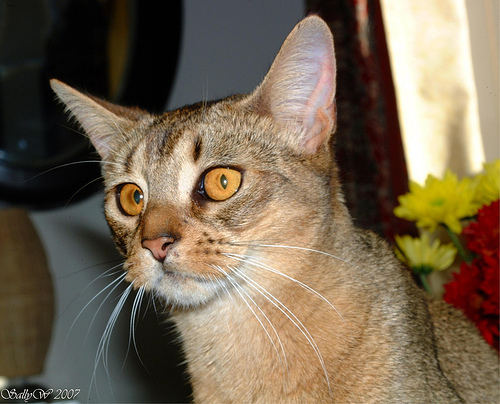

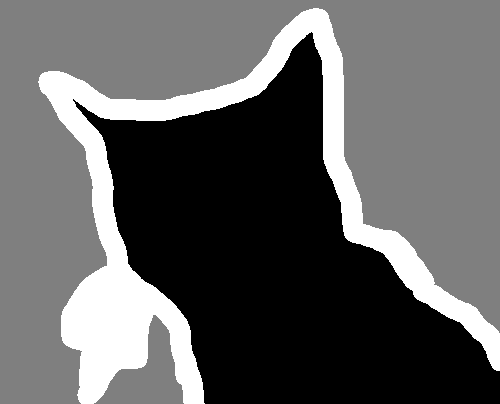

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# Покажем изображение #10
display(Image(filename=input_img_paths[10]))

# Покажем авто-контрастную версию маски (категории попиксельно)
img = ImageOps.autocontrast(load_img(target_img_paths[10]))
display(img)

Подготовим свой источник данных. Основная идея - это должен быть аналог генератора данных изображения, который возвращает нужную нам последовательность.

Реализация подразумевает расширение класса keras.utils.Sequence. Основной код будет написан в переопределении \_\_getitem\_\_ - этот метод будет возвращать 1 пакет (batch) из датасета - изображения и маски.

In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y


Создадим гибридную модель, используя принципы построения сетей U-Net и ResNet.

**Наша сеть будет использовать архитектуру кодер-декодер с обходными соединениями (как у сетей U-Net), но есть различия:**
* обходные соединения не будут идти к строго противоположным блокам
* выходы обходных соединений будут не конкатенироваться, а складываться с выходами слоёв

In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### Первая часть сети: кодер, снижающий размеры карт активации ###

    # Начальный блок
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Запомним и отложим остаток для использования далее

    # Блоки 1,2 и 3 идентичны всем, кроме размеров, так что создадим их в цикле
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Добавим отстаточный блок заново
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  
        previous_block_activation = x  # Отложим следующий остаток

    ### Вторая половина сети - повышение размерности ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Добавим обходной путь заново. Первым будет путь из первой части сети
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  
        previous_block_activation = x 

    # Добавляем попиксельный классификатор
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Собираем модель
    model = keras.Model(inputs, outputs)
    return model


# Освобождаем память на случай многократных пересборок модели
keras.backend.clear_session()

# Получаем модель
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

Подготовим валидационную выборку

In [ ]:
import random

# Разделим наши наборы путей на обучающую и проверочную выборки
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Создадим наши переопределённые последовательности для каждого набора
train_gen = OxfordPets(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

Теперь обучим модель

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

# Полезный пример с callback-функцией: сохраняем нашу сеть по мере обучения,
# но только при условии улучшения результата
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model_history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 66s 283ms/step - loss: 0.9045 - val_loss: 3.0142
Epoch 2/15
199/199 [==============================] - 53s 266ms/step - loss: 0.5110 - val_loss: 2.4702
Epoch 3/15
199/199 [==============================] - 62s 309ms/step - loss: 0.4380 - val_loss: 0.5036
Epoch 4/15
199/199 [==============================] - 66s 330ms/step - loss: 0.3939 - val_loss: 0.3991
Epoch 5/15
199/199 [==============================] - 65s 325ms/step - loss: 0.3631 - val_loss: 0.3812
Epoch 6/15
199/199 [==============================] - 67s 334ms/step - loss: 0.3316 - val_loss: 0.3864
Epoch 7/15
199/199 [==============================] - 59s 294ms/step - loss: 0.3081 - val_loss: 0.3844
Epoch 8/15
199/199 [==============================] - 66s 329ms/step - loss: 0.2873 - val_loss: 0.3811
Epoch 9/15
199/199 [==============================] - 63s 318ms/step - loss: 0.2681 - val_loss: 0.4113
Epoch 10/15
199/199 [==============================] - 52s 263ms/step - l

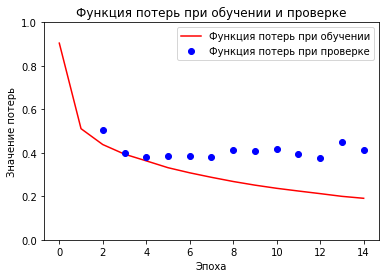

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Функция потерь при обучении')
plt.plot(model_history.epoch, val_loss, 'bo', label='Функция потерь при проверке')
plt.title('Функция потерь при обучении и проверке')
plt.xlabel('Эпоха')
plt.ylabel('Значение потерь')
plt.ylim([0, 1])
plt.legend()
plt.show()

Визуализируем предсказания

31/31 [==============================] - 9s 279ms/step


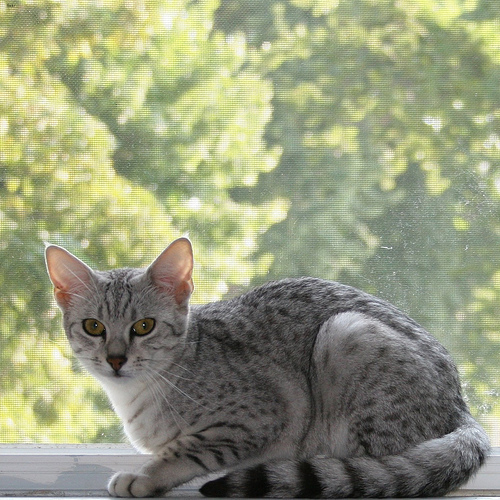

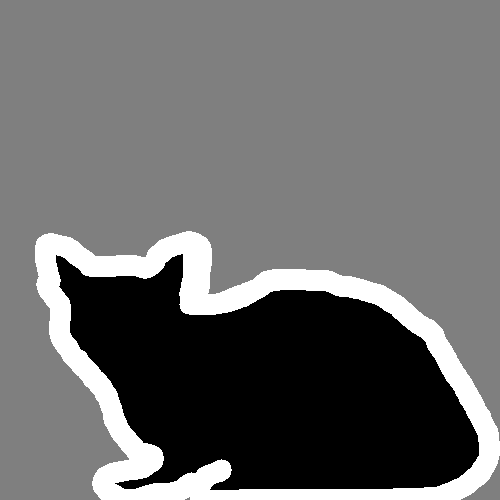

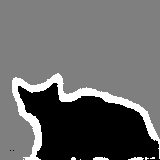

In [ ]:
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Посмотрим результат для изображения под индексом #7
i = 20

# Отобразим исходное
display(Image(filename=val_input_img_paths[i]))

# Отобразим истинную маску
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Отобразим маску, сгенерированную нашей моделью
display_mask(i)

# ВНИМАНИЕ! Наша нейросеть обучена обрабатывать изображения 128х128 и выдавать такой же результат

## Задание

1. Найти датасет для сегментации и обучить полностью свёрточную нейронную сеть сегментации на выбранном датасете. 
2. Для набора данных домашних питомцев реализуйте функции потерь, которые учитывают ложно-положительные и ложно-отрицательные срабатывания, и обучите с ними сеть U-Net. Сравните результаты.
Предлагается воспользоваться функцией Dice Loss: https://pycad.co/the-difference-between-dice-and-dice-loss/
Поясните, что меняется в обучении сети и разницу в результате.

*Дополнительное задание*
Реализуйте классическую сеть U-Net и выполните ей сегментацию.

Пояснения:

Вам понадобится сохранять выход каждого понижающего блока. Затем, при создании повышающих блоков надо будет подавать на следующий не просто выход предыдущего, а выход, сконкатенированный с выходом аналогичного понижающего. Примерный алгоритм создания сети будет выглядеть так:
* в цикле создаём понижающие блоки, соединяя их в обычную свёрточную сеть, но запоминаем выход каждого блока
* в другом цикле создаём повышающие блоки, но на вход следующего повышающего подаём не просто выхо дпредыдущего, а его конкатенацию (tf.keras.layers.Concatenate) с запомненным соответствующим выходом понижающего.

Примеры создания блоков можете почерпнуть здесь: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb